In [1]:
!pip install transformers datasets
!pip install transformers datasets -q
!pip install datasets
!pip install imblearn
!pip install datasets transformers scikit-learn --quiet
!pip install -q transformers datasets evaluate accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [2]:
import pandas as pd

lfc_lda_url = 'https://raw.githubusercontent.com/WinNatch/UoB_SM-WA/main/LFC_LDA.csv'

lfc_df = pd.read_csv(lfc_lda_url)

print(lfc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7547 entries, 0 to 7546
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        7547 non-null   object
 1   time        1970 non-null   object
 2   headline    7547 non-null   object
 3   news_text   7547 non-null   object
 4   reporter    7547 non-null   object
 5   news        7547 non-null   object
 6   clean_news  7547 non-null   object
 7   lda_no      7547 non-null   int64 
 8   lda_topic   5624 non-null   object
dtypes: int64(1), object(8)
memory usage: 530.8+ KB
None


In [3]:
lfc_df["lda_topic"] = lfc_df["lda_topic"].replace({
    "24-25 Summer Market": "Summer Market",
    "LFC Derby Drama": "LFC Derby",
    "Salah contract": "Mohamed Salah",
    "LFC-Alonso": "Klopp Replacement",
    "LFC Derby": "Performance Analysis",
    "VanDijk Contract Renew": "Van Dijk"
})

In [4]:
import pandas as pd

lfc_url = "https://github.com/WinNatch/UoB_SM-WA/raw/main/lfc_sen_new.xlsx"
lfc_stm = pd.read_excel(lfc_url)

lda_topic_mapping = {
    "24-25 Summer Market": "Summer Market",
    "LFC Derby Drama": "LFC Derby",
    "Salah contract": "Mohamed Salah",
    "LFC-Alonso": "Klopp Replacement",
    "LFC Derby": "Performance Analysis",
    "VanDijk Contract Renew": "Van Dijk"
}
lfc_stm["lda_topic"] = lfc_stm["lda_topic"].replace(lda_topic_mapping)

lfc_stm = lfc_stm.drop(columns=["time"], errors="ignore")

lfc_stm = lfc_stm[lfc_stm["news_text"].notna()]
lfc_stm = lfc_stm[lfc_stm["news_text"].str.strip() != ""]

lfc_stm.head()

,date,headline,news_text,reporter,news,clean_news,lda_no,lda_topic,month,Sentiment_M,vader_label,new_sentiment
0,5/1/2024,Jurgen Klopp could get surprise new job offer ...,Jurgen Klopp will take a deserved break follow...,ThisIsAnfield,Jurgen Klopp could get surprise new job offer ...,jurgen klopp could get surprise new job offer ...,7,Klopp Last Season,2024-05,Neutral,Negative,Neutral
1,2/14/2025,Aston Villa made IMPOSSIBLE request to move Li...,Aston Villa have seen a strange request to res...,ThisIsAnfield,Aston Villa made IMPOSSIBLE request to move Li...,aston villa made impossible request move fixtu...,5,Matchday Promote,2025-02,Neutral,Negative,Negative
2,10/23/2024,Leipzig 0-1 Liverpool: Nunez goal provides pro...,"It wasn??t a classic but it needn??t to be, ...",ThisIsAnfield,Leipzig 0-1 Liverpool: Nunez goal provides pro...,leipzig nunez goal provides professional europ...,-1,NaN,2024-10,Positive,Positive,Positive
3,3/2/2025,"Female Liverpool fans may be in for ""surprise""...",With International Women??s Day around the co...,ThisIsAnfield,"Female Liverpool fans may be in for ""surprise""...",female fans may surprise inspiring event next ...,43,LFC Women Team,2025-03,Positive,Positive,Positive
4,3/2/2024,"""I would never try to wind Darwin up!"" - Jurge...",Darwin Nunez??s introduction from the bench s...,ThisIsAnfield,"""I would never try to wind Darwin up!"" - Jurge...",would never try wind darwin jurgen klopp st an...,-1,NaN,2024-03,Negative,Positive,Positive


**Sentiment Analysis**

In [5]:
from nltk.corpus import stopwords
from nltk import download

download('stopwords')

nltk_stopwords = set(stopwords.words("english"))

custom_stopwords_sen = nltk_stopwords.union({
    # Coaching Staff 2023–2024 Season
    'jurgen', 'klopp', 'klopps', 'pepijn', 'lijnders', 'peter', 'krawietz',
    'john', 'achterberg', 'claudio', 'taffarel', 'andreas', 'kornmayer',

    # Common football terms (not useful for context)
    'match', 'goal', 'win', 'team', 'game', 'club', 'cup', 'season', 'player', 'manager', 'centre', 'back', 'football', 'wembley',
    'squad', 'side', 'performance', 'victory', 'score', 'final', 'campaign', 'start', 'position', 'result', 'supporter', 'end',
    'sport', 'defender', 'midfielder', 'forward', 'captain', 'goalkeeper', 'playmaker', 'teammate', 'fixture', 'fan', 'point', 'striker',
    'draw', 'competition', 'title', 'training', 'sign', 'signing', 'deal', 'offer', 'loan', 'penalty', 'scored', 'transfer', 'window',

    # Tournament Name
    'premier', 'league', 'ucl', 'europa', 'carabao', 'fa', 'uefa', 'fifa', 'championship', 'champion',

    # Days of the week and time related word
    'sunday', 'saturday', 'wednesday', 'friday', 'tuesday', 'monday', 'thursday', 'weekend', 'year', 'night', 'evening', 'afternoon', 'morning', 'preseason',

    # Months of the year
    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december',

    # Common football/journalistic phrases
    'last', 'summer', 'may', 'made', 'confirmed', 'following', 'next', 'take', 'put',
    'left', 'face', 'level', 'lot', 'half', 'record', 'former', 'strong', 'contract',
    'likely', 'expect', 'number', 'report', 'weekend', 'home', 'away', 'say', 'told', 'early', 'break', 'international', 'keep', 'kept',

    # Managerial words
    'coach', 'head', 'role', 'manager',

    # Number
    'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen', 'sixteen', 'seventeen', 'eighteen', 'nineteen', 'twenty',

    # Miscellaneous filler words
    'one', 'back', 'away', 'though', 'far', 'way', 'big', 'moment', 'move', 'made', 'take', 'news',
    'time', 'plan', 'really', 'change', 'need', 'always', 'think', 'given', 'england', 'big', 'man',

    # Other unnecessary terms
    'yearold', 'today', 'yesterday', 'tomorrow', 'said', 'says', 'week', 'month', 'day', 'already', 'new', 'thing',
    'still', 'good', 'best', 'first', 'second', 'time', 'minute', 'another', 'expected', 'well', 'thought', 'want', 'await',
    'going', 'know', 'needed', 'return', 'start', 'change', 'talk', 'chance', 'show', 'play', 'played', 'everything', 'every',

    # Liverpool-related terms (team, stadium, sponsors)
    'liverpool', 'lfc', 'anfield', 'axa', 'carabao', 'reds', 'kop', 'scouser', 'ynwa', 'merseyside', 'red',

    # Coaching Staff 2024–2025 Season
    'arne', 'slot', 'sipke', 'hulshoff', 'john', 'heitinga', 'fabian', 'otte',
    'claudio', 'taffarel', 'aaron', 'briggs', 'jonathan', 'power', 'lee', 'nobes',
    'conall', 'murtagh', 'ruben', 'peeters', 'chris', 'morgan', 'amit', 'pannu',
    'robin', 'sadler', 'paul', 'small', 'lee', 'radcliffe', 'brendan', 'mcilduff',
    'david', 'rydings', 'mona', 'nemmer', 'james', 'french', 'chris', 'black',
    'joe', 'lewis', 'clare', 'farrell', 'yinka', 'ademuyiwa', 'michelle', 'hudson', 'lynsey', 'ahmed',

    # Filler Words (Contextually Irrelevant)
    'see', 'look', 'came', 'came', 'making', 'taking', 'set', 'came', 'give', 'got', 'ahead', 'saw', 'yet', 'without', 'make', 'come',
    'remain', 'early', 'late', 'interest', 'decision', 'including', 'revealed', 'situation', 'part', 'much', 'place', 'visit', 'many', 'right',
    'charge', 'situation', 'explain', 'hope', 'better', 'key', 'due', 'stay', 'came', 'future', 'past', 'leave', 'recent', 'almost', 'include',

    # Fenway Sports Group (FSG) & Key Personnel
    'fsg', 'fenway', 'sports', 'group',  # Adding "FSG" and its variations
    'john', 'henry', 'tom', 'werner', 'michael', 'gordon', 'sam', 'kennedy',
    'lebron', 'james', 'maverick', 'carter', 'paul', 'wachter', 'adam', 'grossman',
    'ryan', 'fischer', 'theo', 'epstein', 'billy', 'hogan', 'ed', 'weiss', 'julie', 'swinehart',

    # Player names (to remove bias in LDA and sentiment)
    'alisson', 'adrian', 'caoimhin', 'kelleher', 'trent', 'alexanderarnold', 'alexander', 'arnold',
    'joe', 'gomez', 'virgil', 'van', 'dijk', 'ibrahima', 'konate', 'joel', 'matip', 'mohame',
    'andrew', 'robertson', 'kostas', 'tsimikas', 'nat', 'phillips', 'rhys', 'williams',
    'jarell', 'quansah', 'conor', 'bradley', 'amara', 'nallo', 'wataru', 'endo', 'thiago',
    'dominik', 'szoboszlai', 'alexis', 'mac', 'allister', 'curtis', 'jones', 'harvey', 'elliott',
    'ryan', 'gravenberch', 'tyler', 'morton', 'bobby', 'clark', 'stefan', 'bajcetic',
    'james', 'mcconnell', 'luis', 'diaz', 'darwin', 'nunez', 'mohamed', 'salah', 'diogo', 'jota',
    'cody', 'gakpo', 'federico', 'chiesa', 'kaide', 'gordon', 'ben', 'doak', 'lewis', 'koumas',
    'jayden', 'danns', 'vitezslav', 'jaros', 'harvey', 'davies',

    # Liverpool FC Opponents from January 2024 to March 2025 (Premier League & Domestic Cups)
    'newcastle', 'united', 'afc', 'bournemouth', 'chelsea', 'arsenal', 'burnley',
    'brentford', 'luton', 'town', 'nottingham', 'forest', 'manchester', 'city',
    'brighton', 'hove', 'albion', 'sheffield', 'crystal', 'palace', 'fulham',
    'everton', 'west', 'ham', 'tottenham', 'hotspur', 'aston', 'villa',
    'wolverhampton', 'wanderers', 'ipswich', 'southampton', 'leicester', 'wolf',

    # UEFA Champions League & Europa League Opponents
    'milan', 'bologna', 'rb', 'leipzig', 'real', 'madrid', 'girona', 'psv', 'eindhoven',
    'lille', 'psg', 'paris', 'saintgermain', 'lask', 'union', 'gilloise', 'toulouse',
    'sparta', 'prague', 'atalanta', 'leverkusen'
})

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
import pandas as pd
import re
import spacy
from nltk.corpus import stopwords
from nltk import download
from tqdm import tqdm

lfc_df = lfc_df[lfc_df["news_text"].notna()]
lfc_df = lfc_df[lfc_df["news_text"].str.strip() != ""]

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def build_full_text(df):
    df['headline'] = df['headline'].fillna('').astype(str)
    df['news_text'] = df['news_text'].fillna('').astype(str)
    df['full_text'] = df['headline'] + ' ' + df['news_text']
    return df

lfc_stm = build_full_text(lfc_stm)
lfc_df = build_full_text(lfc_df)

def clean_and_lemmatize(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|[^a-z\s]", " ", text)
    doc = nlp(text)
    tokens = [
        token.lemma_ for token in doc
        if token.lemma_ not in custom_stopwords_sen and len(token.lemma_) > 2 and token.is_alpha
    ]
    return " ".join(tokens)

tqdm.pandas()
lfc_stm['clean_news_st'] = lfc_stm['full_text'].progress_apply(clean_and_lemmatize)
lfc_df['clean_news_st'] = lfc_df['full_text'].progress_apply(clean_and_lemmatize)
lfc_stm['clean_head_st'] = lfc_stm['headline'].progress_apply(clean_and_lemmatize)
lfc_df['clean_head_st'] = lfc_df['headline'].progress_apply(clean_and_lemmatize)

100%|██████████| 7547/7547 [00:20<00:00, 365.41it/s]


In [7]:
print(lfc_stm.info())
print(lfc_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   date           1001 non-null   object
 1   headline       1001 non-null   object
 2   news_text      1001 non-null   object
 3   reporter       1001 non-null   object
 4   news           1001 non-null   object
 5   clean_news     1001 non-null   object
 6   lda_no         1001 non-null   int64 
 7   lda_topic      740 non-null    object
 8   month          1001 non-null   object
 9   Sentiment_M    1001 non-null   object
 10  vader_label    1001 non-null   object
 11  new_sentiment  1001 non-null   object
 12  full_text      1001 non-null   object
 13  clean_news_st  1001 non-null   object
 14  clean_head_st  1001 non-null   object
dtypes: int64(1), object(14)
memory usage: 117.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7547 entries, 0 to 7546
Data columns (total 12 columns

<ipython-input-8-59b2610e8701>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-8-59b2610e8701>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-8-59b2610e8701>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


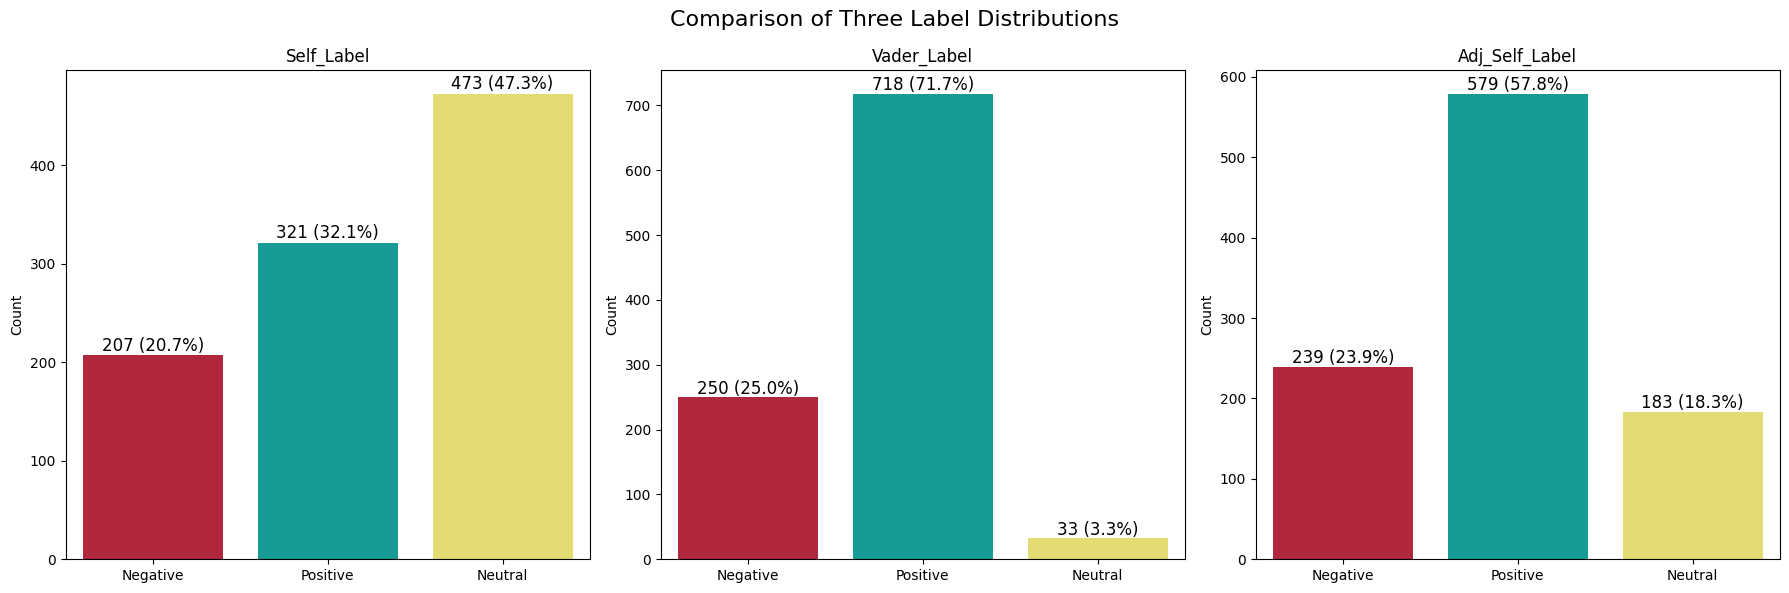

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

color_map = {
    "Negative": "#C8102E",
    "Positive": "#00B2A9",
    "Neutral": "#F6EB61",
}

def plot_three_distributions(dist1, dist2, dist3, label_order):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    dists = [dist1, dist2, dist3]
    titles = ["Self_Label", "Vader_Label", "Adj_Self_Label"]

    for ax, data, title in zip(axes, dists, titles):
        total = data.sum()
        sns.barplot(
            x=data.index,
            y=data.values,
            ax=ax,
            palette=[color_map[label] for label in label_order],
            order=label_order
        )

        for i, v in enumerate(data[label_order]):
            ax.text(i, v + 5, f"{v} ({v/total:.1%})", ha='center', fontsize=12)
        ax.set_title(title)
        ax.set_ylabel("Count")
        ax.set_xlabel("")

    fig.suptitle("Comparison of Three Label Distributions", fontsize=16)
    plt.tight_layout()
    plt.show()

label_order = ["Negative", "Positive", "Neutral"]
dist1 = lfc_stm['Sentiment_M'].value_counts()
dist2 = lfc_stm['vader_label'].value_counts()
dist3 = lfc_stm['new_sentiment'].value_counts()

plot_three_distributions(dist1, dist2, dist3, label_order)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

color_map = {
    "Negative": "#C8102E",
    "Positive": "#00B2A9",
    "Neutral": "#F6EB61",
}

label_counts_before = lfc_stm['Sentiment_M'].value_counts()

def plot_label_distribution(before, after, label_order):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    for ax, data, title in zip(
        axes,
        [before, after],
        ["Before SMOTE", "After SMOTE (Train Set)"]
    ):
        total = data.sum()
        sns.barplot(
            x=data.index,
            y=data.values,
            ax=ax,
            palette=[color_map[label] for label in label_order],
            order=label_order
        )
        for i, v in enumerate(data[label_order]):
            ax.text(i, v + 5, f"{v} ({v/total:.1%})", ha='center', fontsize=12)
        ax.set_title(title)
        ax.set_ylabel("Count")
        ax.set_xlabel("Sentiment")
    fig.suptitle("Sentiment Label Distribution: Before vs After SMOTE", fontsize=16)
    plt.tight_layout()
    plt.show()

<ipython-input-9-601d2735d3b3>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-9-601d2735d3b3>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


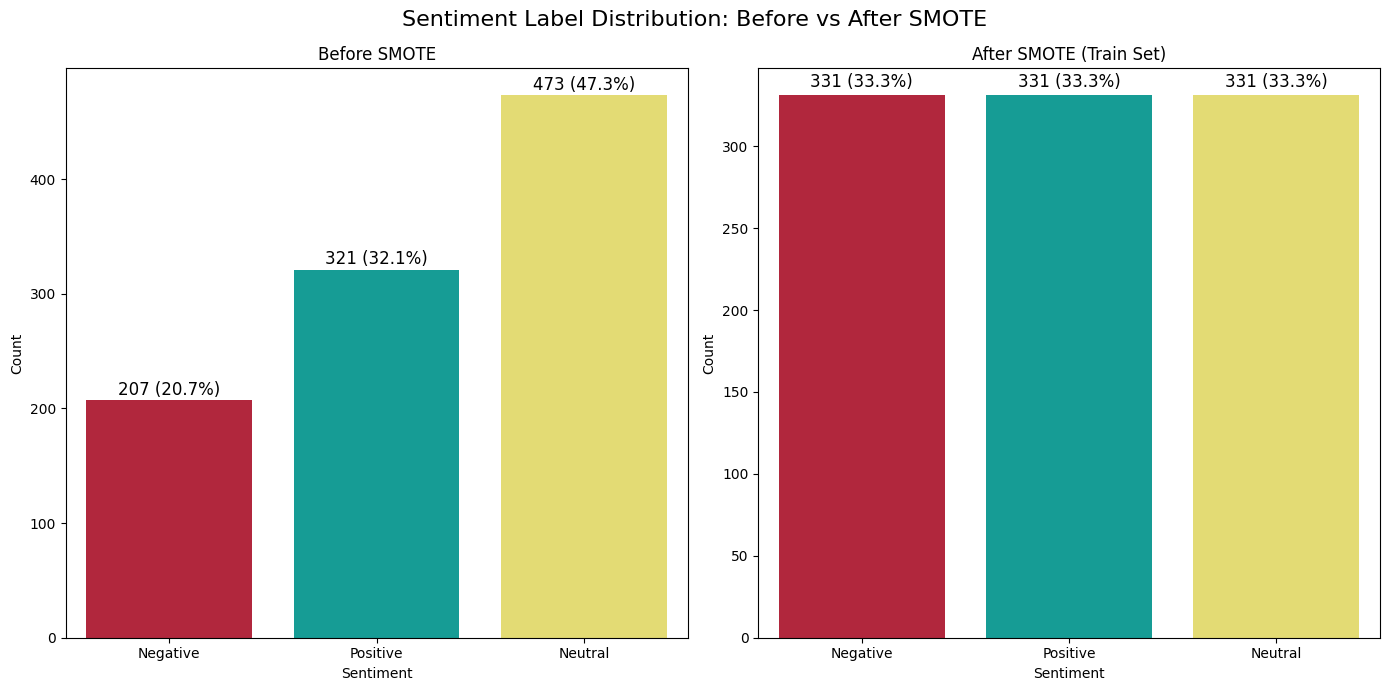

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

le = LabelEncoder()
lfc_stm['label'] = le.fit_transform(lfc_stm['Sentiment_M'])

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(lfc_stm['clean_news_st'])
y = lfc_stm['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

after_counts = pd.Series(le.inverse_transform(y_train_resampled)).value_counts()

label_order = ["Negative", "Positive", "Neutral"]
plot_label_distribution(label_counts_before, after_counts, label_order)

In [11]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments
)
import torch
import evaluate
import numpy as np

sentiment_mapping = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

lfc_stm['label'] = lfc_stm['Sentiment_M'].map(sentiment_mapping)

id2label = {v: k for k, v in sentiment_mapping.items()}
label2id = sentiment_mapping

train_df, test_df = train_test_split(
    lfc_stm[['clean_news_st', 'label']],
    test_size=0.3,
    stratify=lfc_stm['label'],
    random_state=42
)

hf_dataset = {
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
}

In [12]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

def fine_tune_model(model_ckpt, output_dir):
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

    def tokenize(batch):
        return tokenizer(batch["clean_news_st"], truncation=True, padding=True)

    tokenized_ds = {
        "train": hf_dataset["train"].map(tokenize, batched=True),
        "test": hf_dataset["test"].map(tokenize, batched=True)
    }

    model = AutoModelForSequenceClassification.from_pretrained(
        model_ckpt,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id
    )

    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        logging_dir=f"{output_dir}/logs",
        num_train_epochs=5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    trainer.train()

    return model, tokenizer, trainer, tokenized_ds

train_df, test_df = train_test_split(
    lfc_stm[['clean_news_st', 'label']],
    test_size=0.3,
    stratify=lfc_stm['label'],
    random_state=42
)

hf_dataset = {
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True))
}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
def predict_sentiment(df, model, tokenizer, col_name, batch_size=32):
    model.eval()
    device = model.device

    texts = df['clean_news_st'].dropna().tolist()
    preds = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        encodings = tokenizer(batch_texts, truncation=True, padding=True, return_tensors="pt")
        encodings = {k: v.to(device) for k, v in encodings.items()}

        with torch.no_grad():
            outputs = model(**encodings)
            batch_preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)

    df = df.copy()
    df = df.loc[df['clean_news_st'].notna()].reset_index(drop=True)
    df[col_name] = [id2label[p] for p in preds]

    return df

In [14]:
import os
os.environ["WANDB_DISABLED"] = "true"

# Fine-tune BERT model
bert_model, bert_tokenizer, bert_trainer, bert_tokenized_ds = fine_tune_model("bert-base-uncased", "./bert")

bert_train_results = bert_trainer.evaluate(eval_dataset=bert_tokenized_ds["train"])
bert_test_results = bert_trainer.evaluate(eval_dataset=bert_tokenized_ds["test"])

print("BERT Train Accuracy:", bert_train_results.get("eval_accuracy"))
print("BERT Test Accuracy:", bert_test_results.get("eval_accuracy"))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-12-d43e37c3612a>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.039329,0.491694
2,No log,1.061827,0.485050
3,No log,0.977801,0.591362
4,No log,1.172617,0.601329
5,No log,1.251536,0.584718


BERT Train Accuracy: 0.9314285714285714
BERT Test Accuracy: 0.6013289036544851


In [15]:
# Fine-tune RoBERTa model
roberta_model, roberta_tokenizer, roberta_trainer, roberta_tokenized_ds = fine_tune_model("roberta-base", "./roberta")

roberta_train_results = roberta_trainer.evaluate(eval_dataset=roberta_tokenized_ds["train"])
roberta_test_results = roberta_trainer.evaluate(eval_dataset=roberta_tokenized_ds["test"])

print("RoBERTa Train Accuracy:", roberta_train_results.get("eval_accuracy"))
print("RoBERTa Test Accuracy:", roberta_test_results.get("eval_accuracy"))

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-12-d43e37c3612a>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.070099,0.322259
2,No log,1.044285,0.471761
3,No log,1.065195,0.471761
4,No log,0.972745,0.571429
5,No log,0.962972,0.551495


RoBERTa Train Accuracy: 0.6628571428571428
RoBERTa Test Accuracy: 0.5714285714285714


In [16]:
# Fine-tune Twitter-RoBERTa model
twitter_model, twitter_tokenizer, twitter_trainer, twitter_tokenized_ds = fine_tune_model("cardiffnlp/twitter-roberta-base-sentiment", "./twitter")

twitter_train_results = twitter_trainer.evaluate(eval_dataset=twitter_tokenized_ds["train"])
twitter_test_results = twitter_trainer.evaluate(eval_dataset=twitter_tokenized_ds["test"])

print("Twitter-RoBERTa Train Accuracy:", twitter_train_results.get("eval_accuracy"))
print("Twitter-RoBERTa Test Accuracy:", twitter_test_results.get("eval_accuracy"))

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Map:   0%|          | 0/700 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/301 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-12-d43e37c3612a>:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.960979,0.551495
2,No log,0.968993,0.601329
3,No log,1.203661,0.591362
4,No log,1.557257,0.594684
5,No log,1.666872,0.621262


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Twitter-RoBERTa Train Accuracy: 0.9857142857142858
Twitter-RoBERTa Test Accuracy: 0.6212624584717608


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

colors = ["#F6EB61", "#C8102E"]
custom_cmap = LinearSegmentedColormap.from_list("custom_red_yellow", colors, N=256)

class_names = ["Negative", "Neutral", "Positive"]

def evaluate_transformer_model(name, trainer, ds_train, ds_test):
    train_predictions = trainer.predict(ds_train)
    train_preds = np.argmax(train_predictions.predictions, axis=-1)
    train_labels = train_predictions.label_ids
    train_acc = accuracy_score(train_labels, train_preds)

    test_predictions = trainer.predict(ds_test)
    test_preds = np.argmax(test_predictions.predictions, axis=-1)
    test_labels = test_predictions.label_ids
    test_acc = accuracy_score(test_labels, test_preds)

    print(f"\n📊 {name} Evaluation")
    print("-" * 40)
    print("Train Accuracy:", round(train_acc, 4))
    print("Test Accuracy :", round(test_acc, 4))

    print("\nClassification Report (Test):")
    print(classification_report(test_labels, test_preds, target_names=class_names))

    cm_test = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap=custom_cmap,
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} Confusion Matrix (Test)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


📊 BERT Evaluation
----------------------------------------
Train Accuracy: 0.9314
Test Accuracy : 0.6013

Classification Report (Test):
              precision    recall  f1-score   support

    Negative       0.55      0.44      0.49        62
     Neutral       0.62      0.75      0.68       142
    Positive       0.59      0.49      0.54        97

    accuracy                           0.60       301
   macro avg       0.59      0.56      0.57       301
weighted avg       0.60      0.60      0.59       301



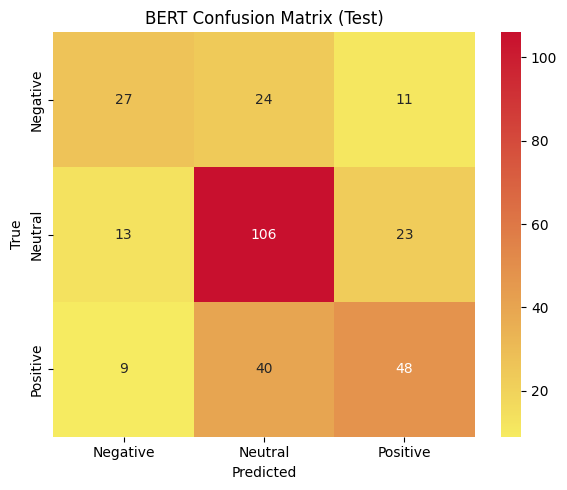


📊 RoBERTa Evaluation
----------------------------------------
Train Accuracy: 0.6629
Test Accuracy : 0.5714

Classification Report (Test):
              precision    recall  f1-score   support

    Negative       0.60      0.50      0.54        62
     Neutral       0.65      0.65      0.65       142
    Positive       0.46      0.49      0.48        97

    accuracy                           0.57       301
   macro avg       0.57      0.55      0.56       301
weighted avg       0.57      0.57      0.57       301



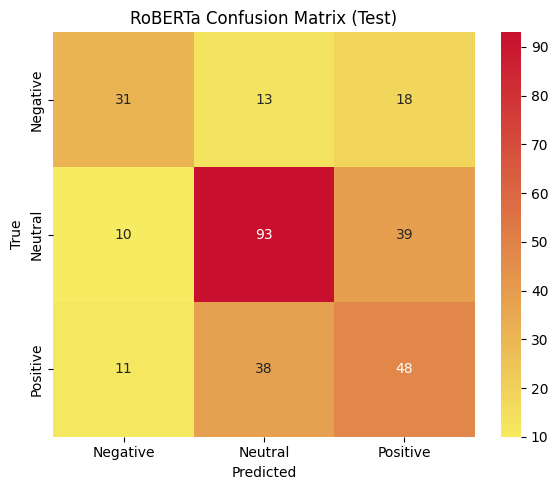


📊 Twitter-RoBERTa Evaluation
----------------------------------------
Train Accuracy: 0.9857
Test Accuracy : 0.6213

Classification Report (Test):
              precision    recall  f1-score   support

    Negative       0.56      0.47      0.51        62
     Neutral       0.63      0.73      0.68       142
    Positive       0.64      0.56      0.60        97

    accuracy                           0.62       301
   macro avg       0.61      0.59      0.59       301
weighted avg       0.62      0.62      0.62       301



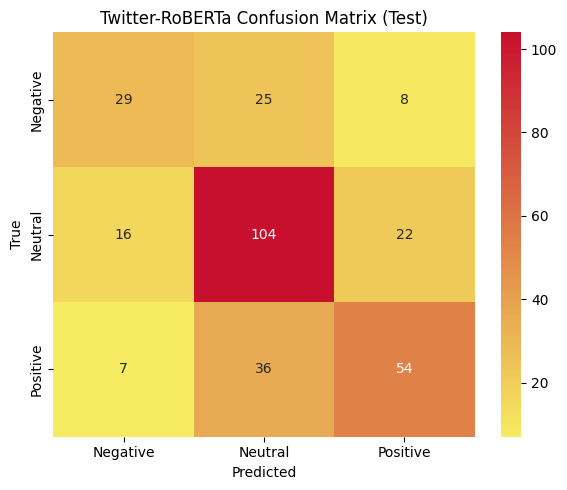

In [18]:
evaluate_transformer_model(
    name="BERT",
    trainer=bert_trainer,
    ds_train=bert_tokenized_ds["train"],
    ds_test=bert_tokenized_ds["test"]
)

evaluate_transformer_model(
    name="RoBERTa",
    trainer=roberta_trainer,
    ds_train=roberta_tokenized_ds["train"],
    ds_test=roberta_tokenized_ds["test"]
)

evaluate_transformer_model(
    name="Twitter-RoBERTa",
    trainer=twitter_trainer,
    ds_train=twitter_tokenized_ds["train"],
    ds_test=twitter_tokenized_ds["test"]
)